# Image Segmentation - Scene Understanding


# HW3 - Segmentation

### Come up with Story

    0. You will work in groups of three. Come up with a team name.

    1. You are given powerful segmentation model, that simulates human annotator labelling the listed classes below

    2. Come up with the interesting (specific use-case) segmentation application on the images you can produce with your phone or gather from internet

    3. State in which situation it can be used, i.e. robot navigating through terrain, catching escaped animals from zoo, safari, collecting food from table etc.

    4. It can be related to your thesis as well

### Design Model

    1. You are given MobileNetV3 as a segmentation architecture. You can use whichever you want, this is just recommended as it is running realtime on gpu and can be tested on cpu

    2. You will train the model (you can use pretrained weights on different scenes) on your collected image data

    3. Split the data to training part and testing part and validate your model on testing part in terms of IoU from Teacher and visualized outputs

    4. Specify some unique scenarios for testing and show loss values and final segmentation on these cases
        - Discuss how it fails or succeded
        - Try to explain why and what you help to improve the performance on these cases

### Things that can help you

    - Strong Regularization
        1. Weight decay in torch optimizer
        2. Data augmentation
        3. Using pretrained model
        4. More training data from unique scenarios
        5. (Advanced) self-supervised pre-training

    - Server GPUs
        1. Taylor and Cantor - ssh username@taylor.felk.cvut.cz or ssh username@cantor.felk.cvut.cz
        2. Video Tutorial in server.mp4
        3. Text guide on: https://cyber.felk.cvut.cz/cs/study/gpu-servers/

### Final Presentation

    1. Describe Idea in sheets: https://docs.google.com/spreadsheets/d/1rvsg9ZgzmXiVJsiJvnpsy-yQ7N5WqADn10NL235eC1M/edit?usp=sharing

    2. Evaluation will be given on the day of presentations - 17./18.12. based on your parralel

### Evaluation

    1. Idea and preparation of data (Unique scenarios, Useful Teacher outputs, amount of training samples)

    2. Training - loss minimization, Validity of approach, Tweaks to training (Regularizations, Augmentation, ...)

    3. Examples and output overview and discussion

    4. Discussion of training times and speed of teacher and inference model. Is it sufficiently fast for the application?

    5. Presentation clarity and enthusiasm


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from pathlib import Path
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "Apple Roboto"
except:
    pass

In [4]:
from fastseg import MobileV3Large
model = MobileV3Large.from_pretrained()

Loading pretrained model mobilev3large-lraspp with F=128...


In [8]:
dataset = "fsoco_segmentation_processed"
dataset_dir = Path(dataset)
imgs_dir = dataset_dir / "img"
masks_dir = dataset_dir / "ann"

In [9]:
processed_imgs = list(imgs_dir.glob("*.jpeg"))
processed_masks = list(masks_dir.glob("*.npz"))
processed_imgs.sort()
processed_masks.sort()
img_mask_pairs = list(zip(processed_imgs, processed_masks))
img_mask_pairs[:5]

[(PosixPath('fsoco_segmentation_processed/img/BME_00006.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00006.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00019.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00019.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00028.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00028.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00039.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00039.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00043.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00043.npz'))]

# Dataset class and augmentations


In [83]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Class IDs to colors
classid_to_color = {
    0: (20, 20, 20),
    1: (192, 71, 42),
    2: (191, 149, 52),
    3: (255, 0, 0),
    4: (0, 0, 255),
    5: (0, 255, 0),
}


class ConeSegmentationDataset(Dataset):
    def __init__(self, img_mask_pairs, transform=None):
        self.img_mask_pairs = img_mask_pairs
        self.transform = transform

    def __len__(self):
        return len(self.img_mask_pairs)

    def __getitem__(self, idx):
        # Load the data
        img_path, mask_path = self.img_mask_pairs[idx]
        img = np.asarray(Image.open(img_path))
        # Convert image into a normalized tensor with batch dim
        img_tensor = torch.tensor(img)
        img_tensor = img_tensor.unsqueeze(
            0).permute(0, 3, 1, 2)
        mask = np.load(mask_path)["arr_0"]
        # Convert 2D mask to N-classes x 2D mask in one hot sense
        one_hot_mask = nn.functional.one_hot(
            torch.from_numpy(mask).long(), num_classes=6)
        one_hot_mask = one_hot_mask.unsqueeze(0).permute(0, 3, 1, 2)
        # Apply transforms
        if self.transform:
            img_tensor, one_hot_mask = self.transform(
                (img_tensor, one_hot_mask))
        return img_tensor.float(), one_hot_mask.float()


class Normalize(object):

    def __init__(self):
        pass

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        img_tensor, mask_tensor = tup
        return (img_tensor - 127.5) / 127.5, mask_tensor


class BaseTransform(object):
    IMG_CHANNELS = 3

    def concat(self, img_tensor, mask_tensor):
        return torch.cat([img_tensor, mask_tensor], dim=1)

    def split(self, img_mask_tensor):
        img_tensor = img_mask_tensor[:, :self.IMG_CHANNELS]
        mask_tensor = img_mask_tensor[:, self.IMG_CHANNELS:]
        return img_tensor, mask_tensor


class RandomCropWithMask(BaseTransform):

    def __init__(self, **kwargs):
        self.crop = transforms.RandomCrop(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be cropped.
        Returns:
            Tensor: Cropped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply crop
        img_mask_tensor = self.crop(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class RandomRotationWithMask(BaseTransform):
    def __init__(self, **kwargs):
        self.rotate = transforms.RandomRotation(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be rotated.
        Returns:
            Tensor: Rotated image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply rotation
        img_mask_tensor = self.rotate(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class ClasswiseColorJitter(BaseTransform):

    """
    Applies color jitter to each class segmentation mask separately
    by the given parameters.
    """

    def __init__(self, class_transform_params: dict):
        assert all([k in classid_to_color.keys()
                   for k in class_transform_params.keys()])
        self.class_transforms = {
            k:  transforms.ColorJitter(**v) for k, v in class_transform_params.items()
        }

    def __call__(self, tup):
        img_tensor, mask_tensor = tup
        for class_id, color_jitter in self.class_transforms.items():
            # Get the mask for this class
            class_mask = mask_tensor[:, class_id].squeeze().bool()
            # Apply color jitter
            img_tensor[:, :, class_mask] = color_jitter(
                img_tensor[:, :, class_mask])
        return img_tensor, mask_tensor


class RandomHorizontalFlipWithMask(BaseTransform):
    def __init__(self, p=0.5):
        self.flip = transforms.RandomHorizontalFlip(p=p)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be flipped.
        Returns:
            Tensor: Flipped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply flip
        img_mask_tensor = self.flip(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class RandomAffineWithMask(BaseTransform):
    def __init__(self, **kwargs):
        self.affine = transforms.RandomAffine(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be flipped.
        Returns:
            Tensor: Flipped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply flip
        img_mask_tensor = self.affine(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor

In [61]:
def visualize_from_torch(img, mask):
    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().permute(1, 2, 0).numpy()
    mask = np.argmax(mask, axis=-1)
    mask_img = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, color in classid_to_color.items():
        mask_img[mask == class_id] = color
    img = (img * 127.5 + 127.5).astype(np.uint8)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), dpi=200)
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask_img)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

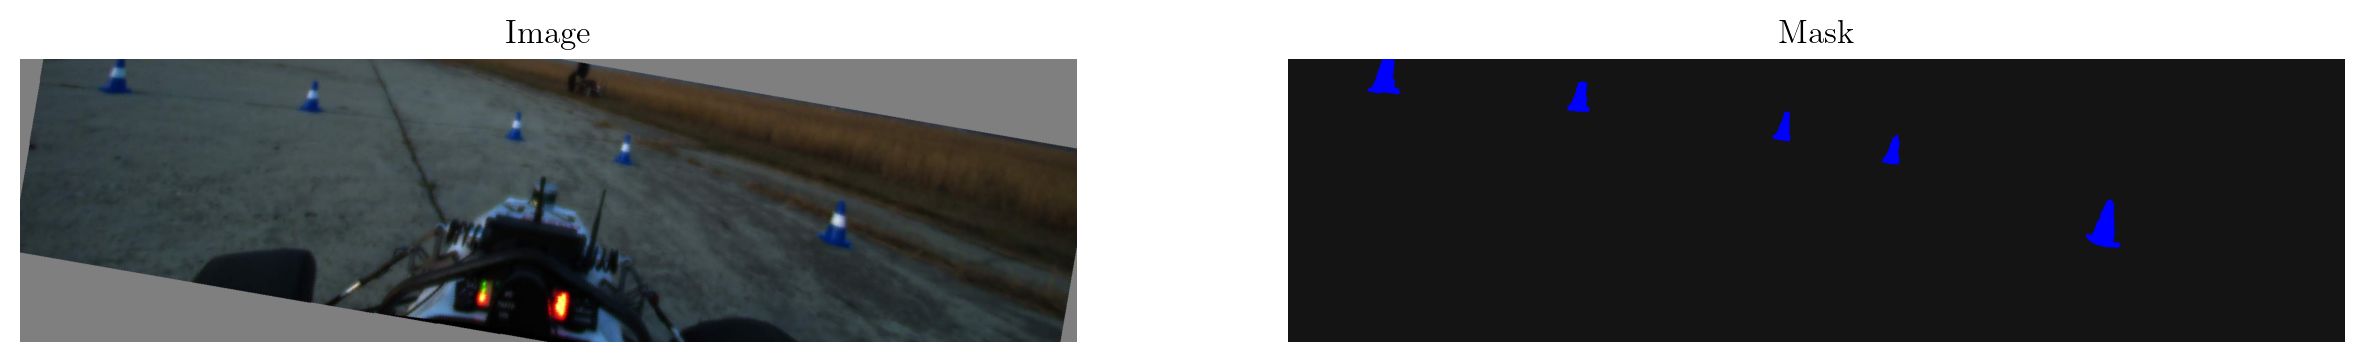

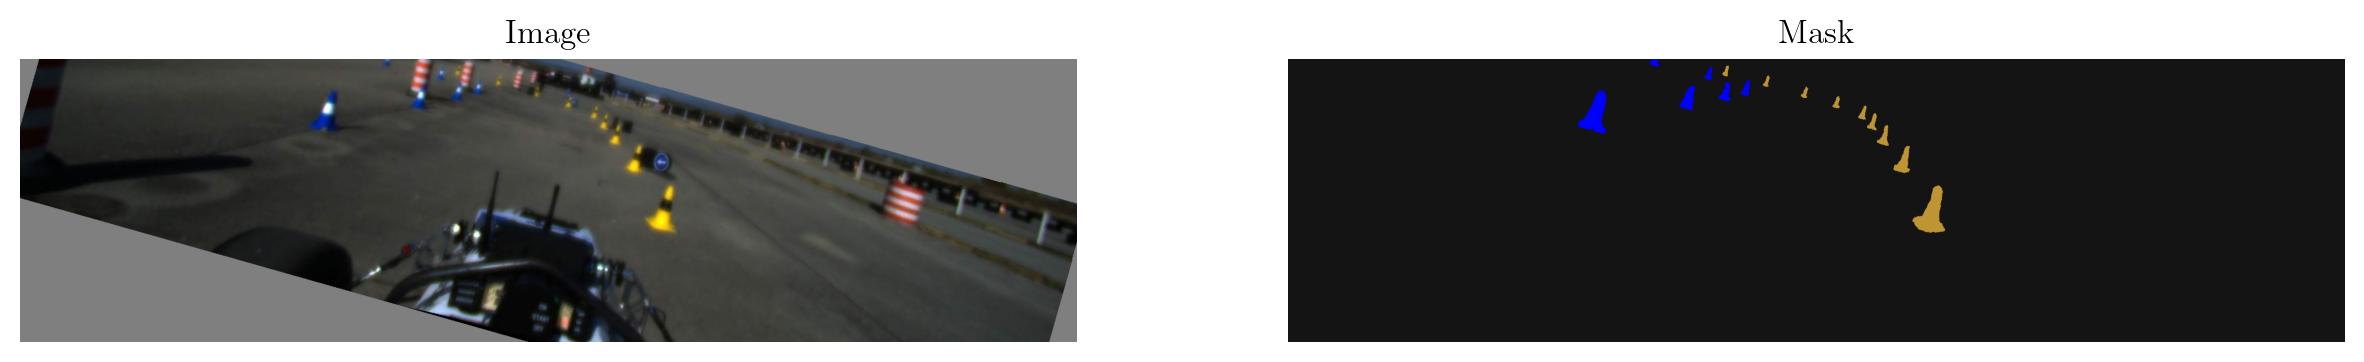

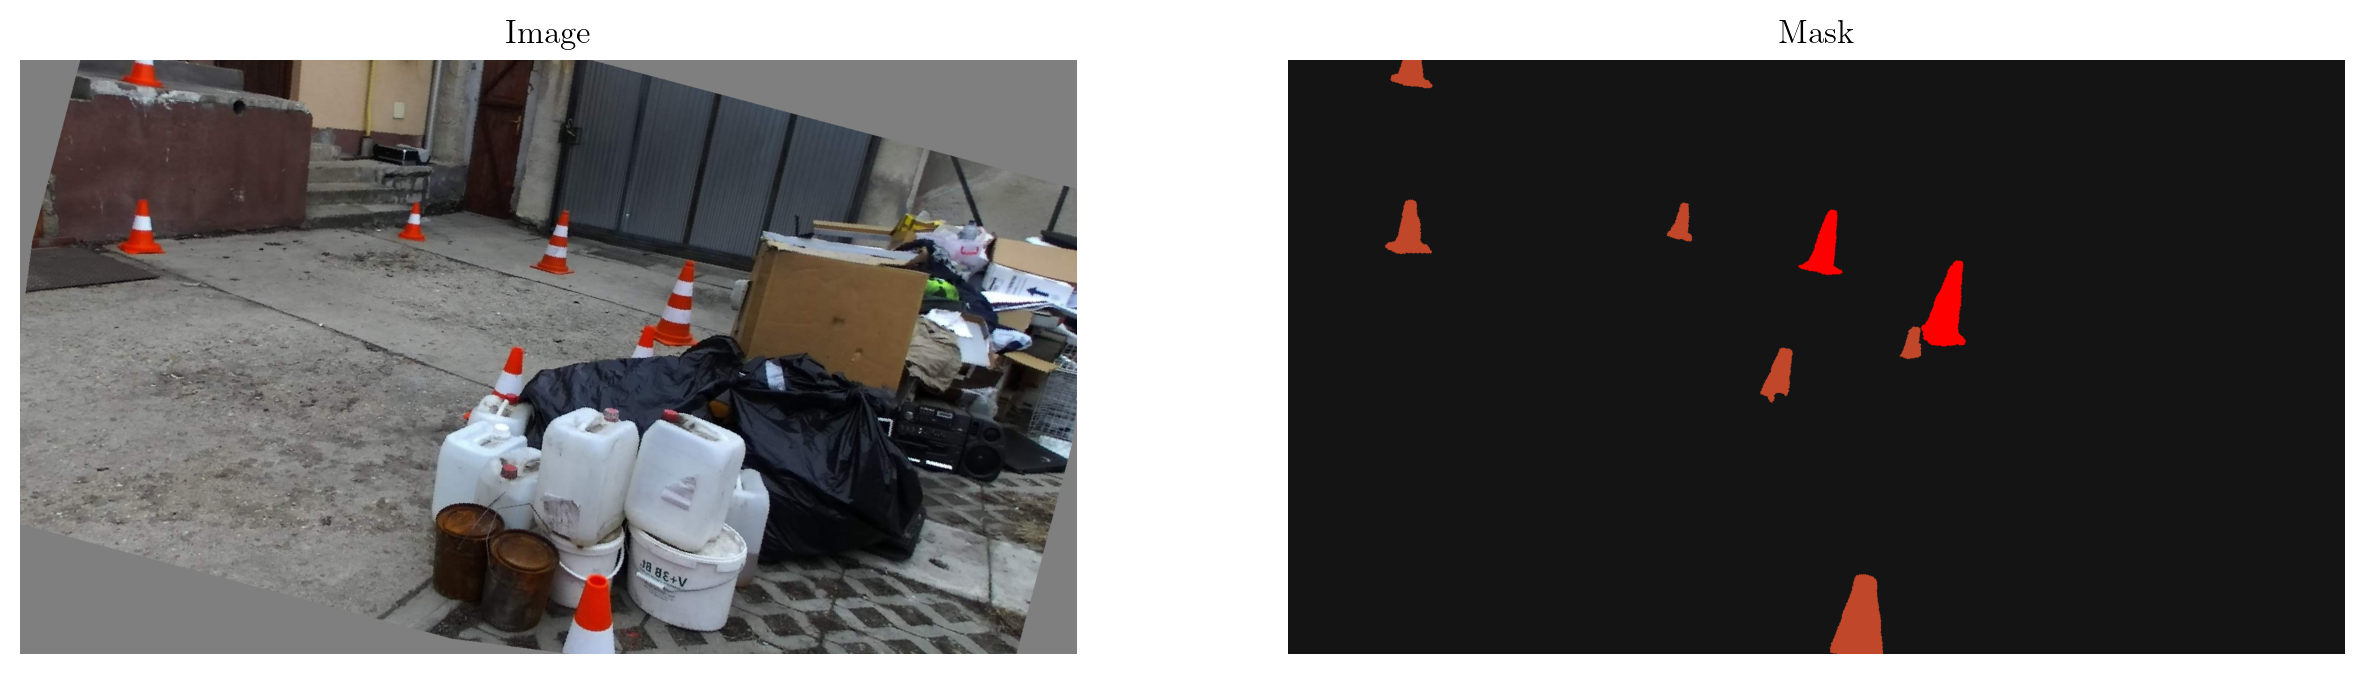

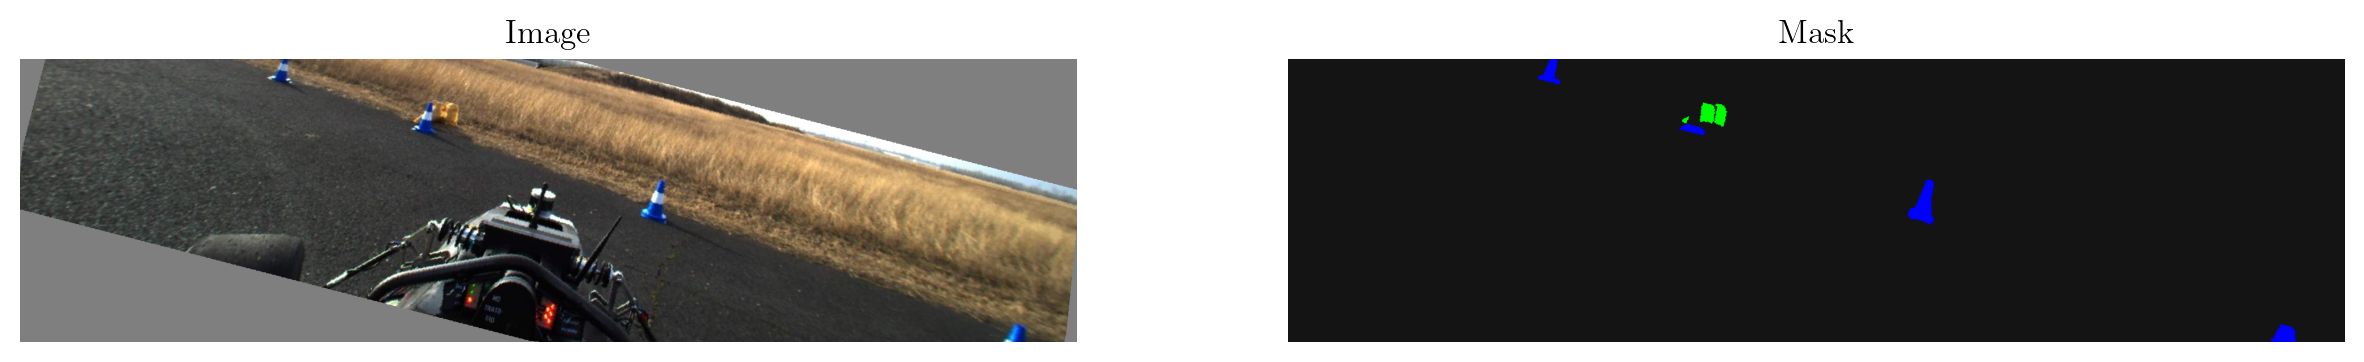

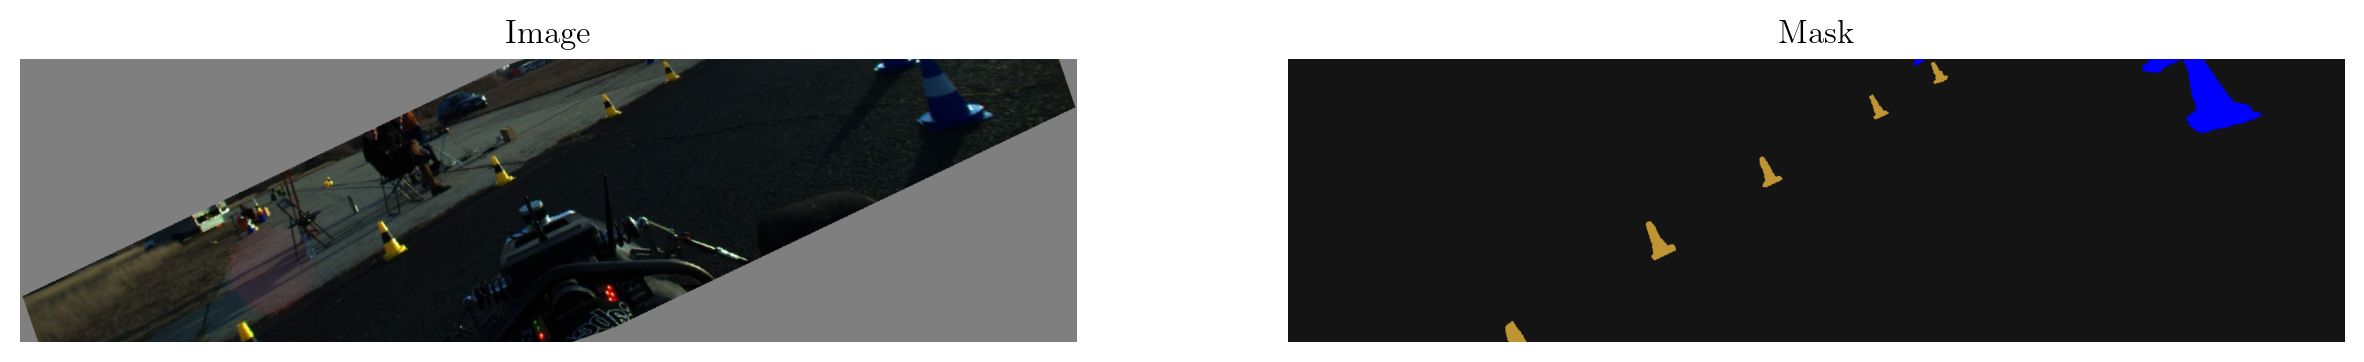

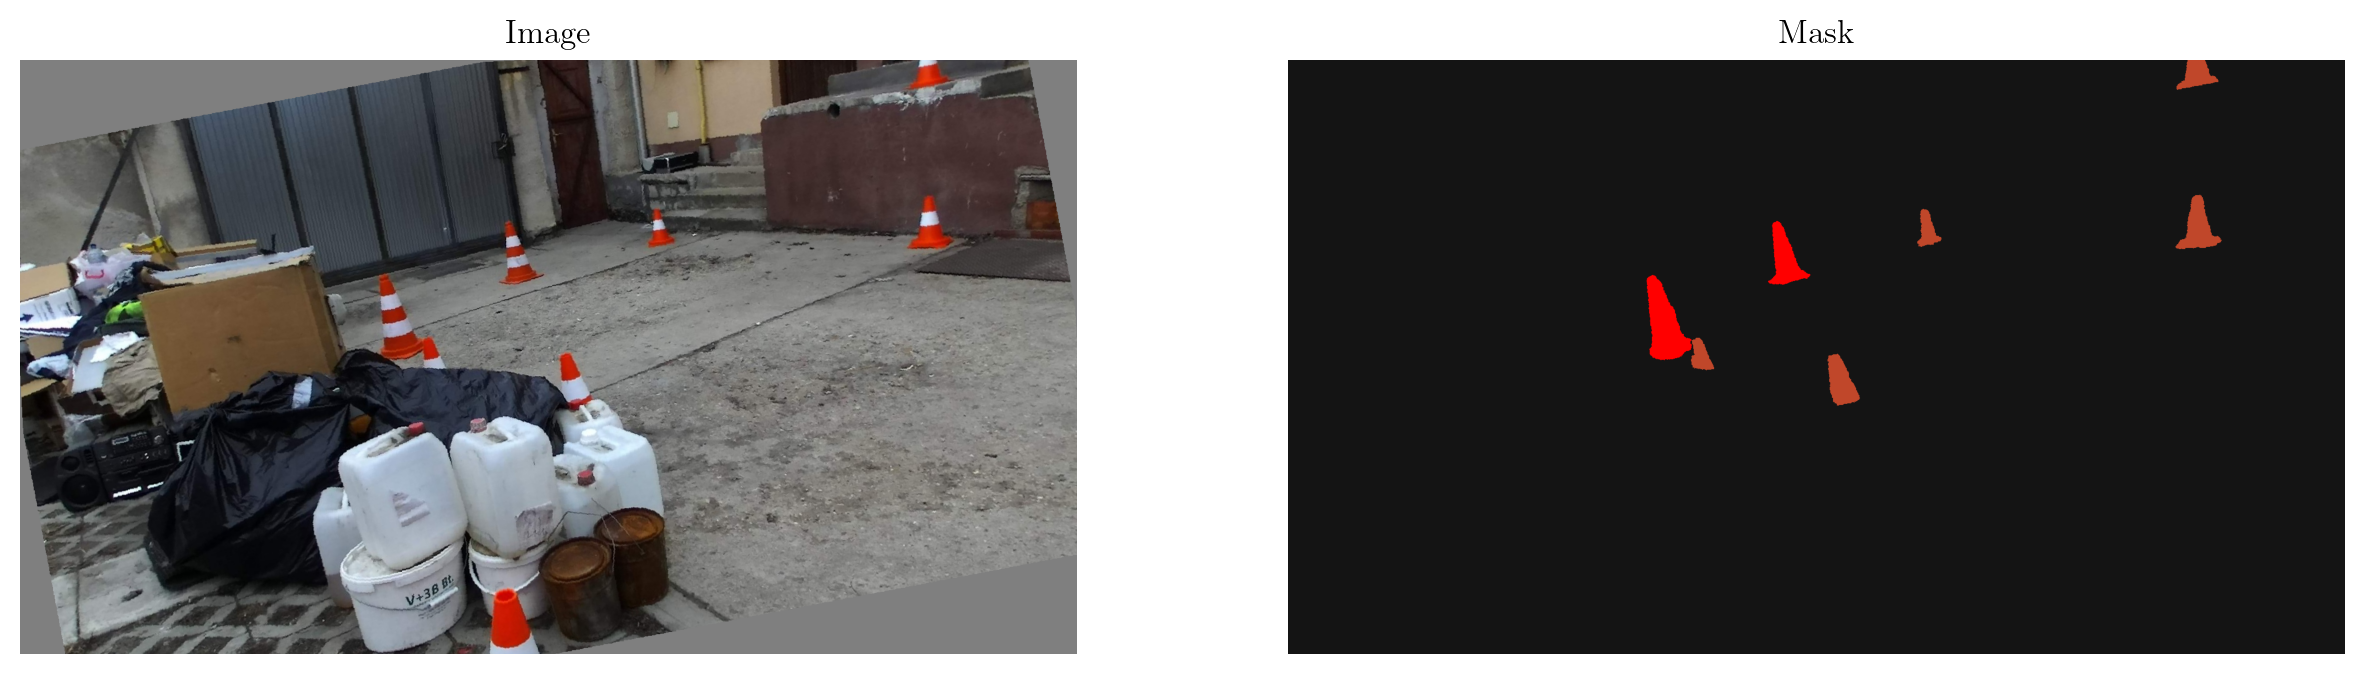

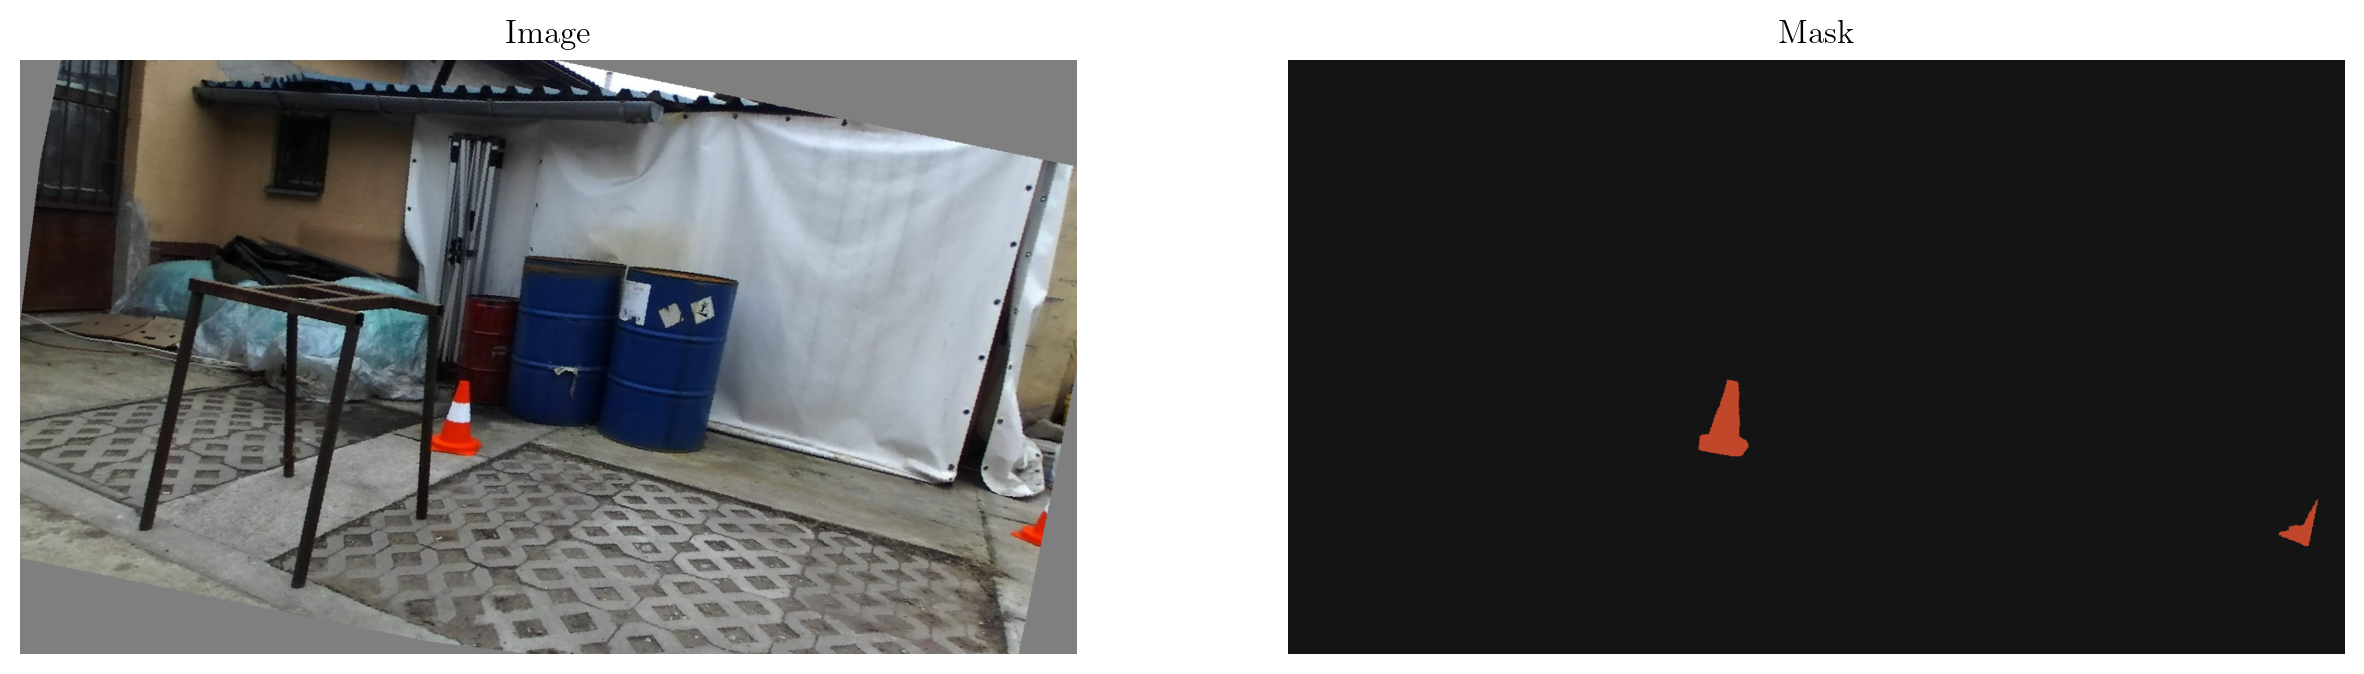

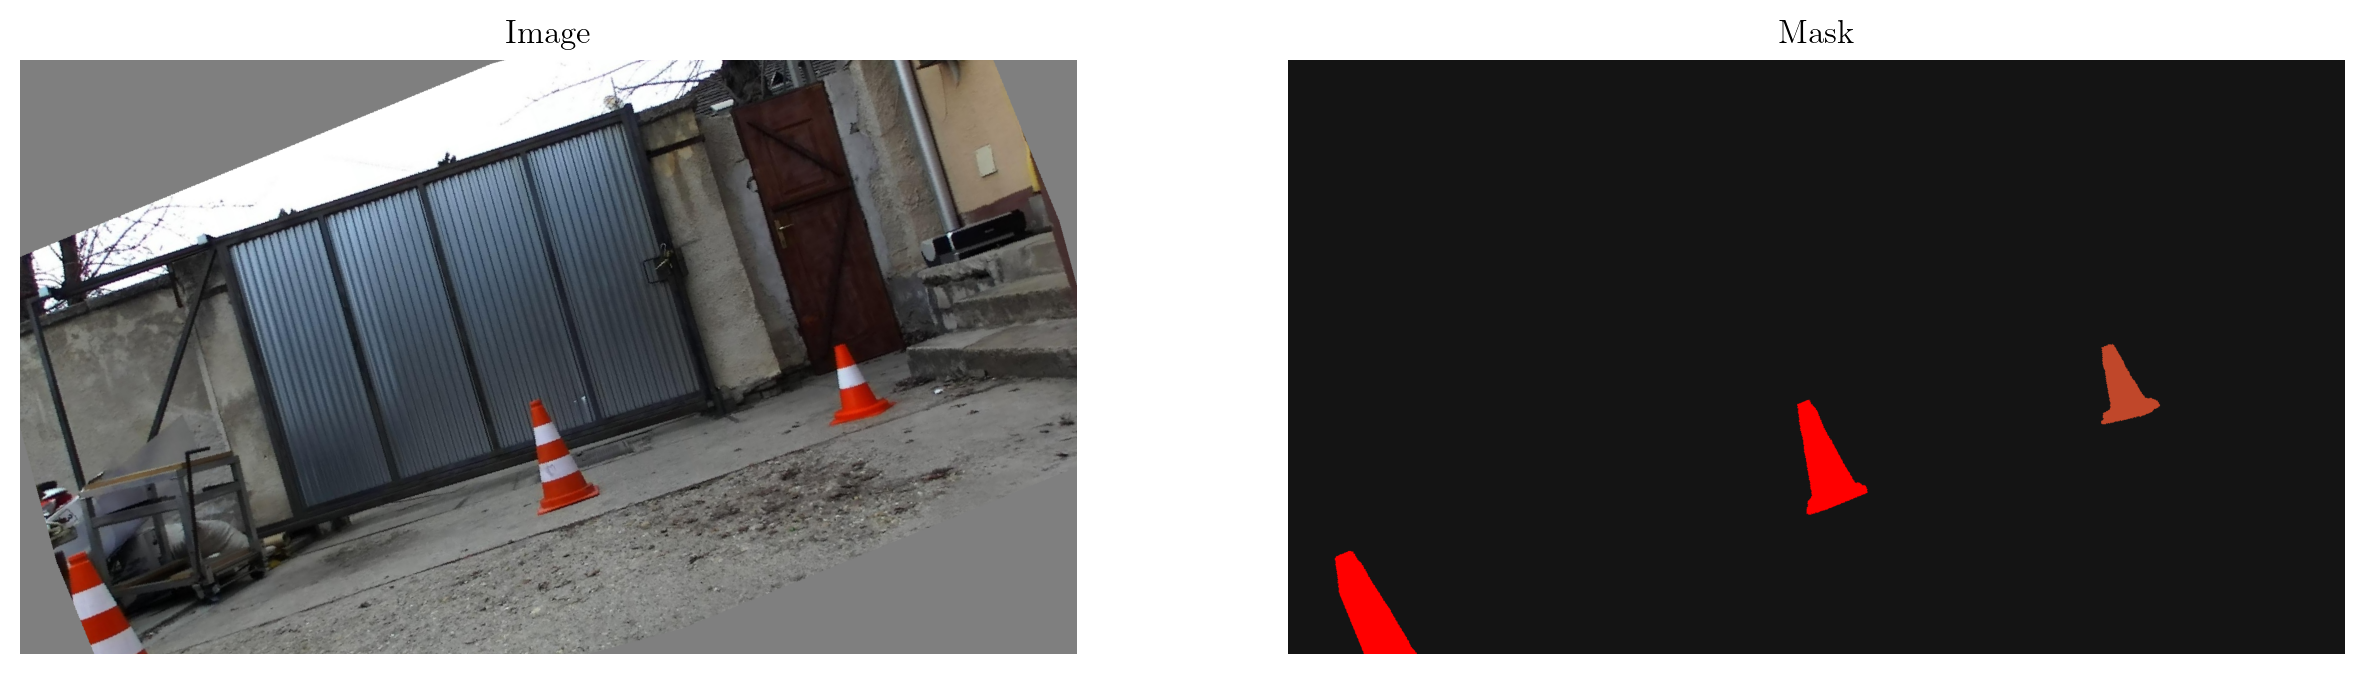

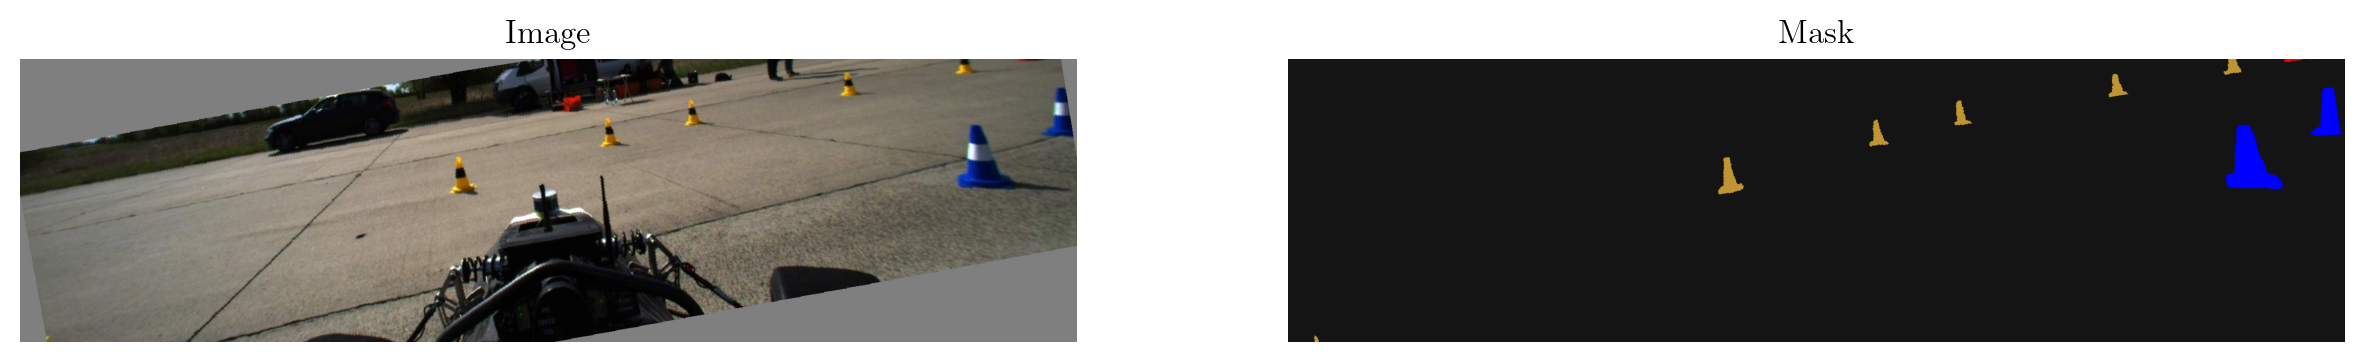

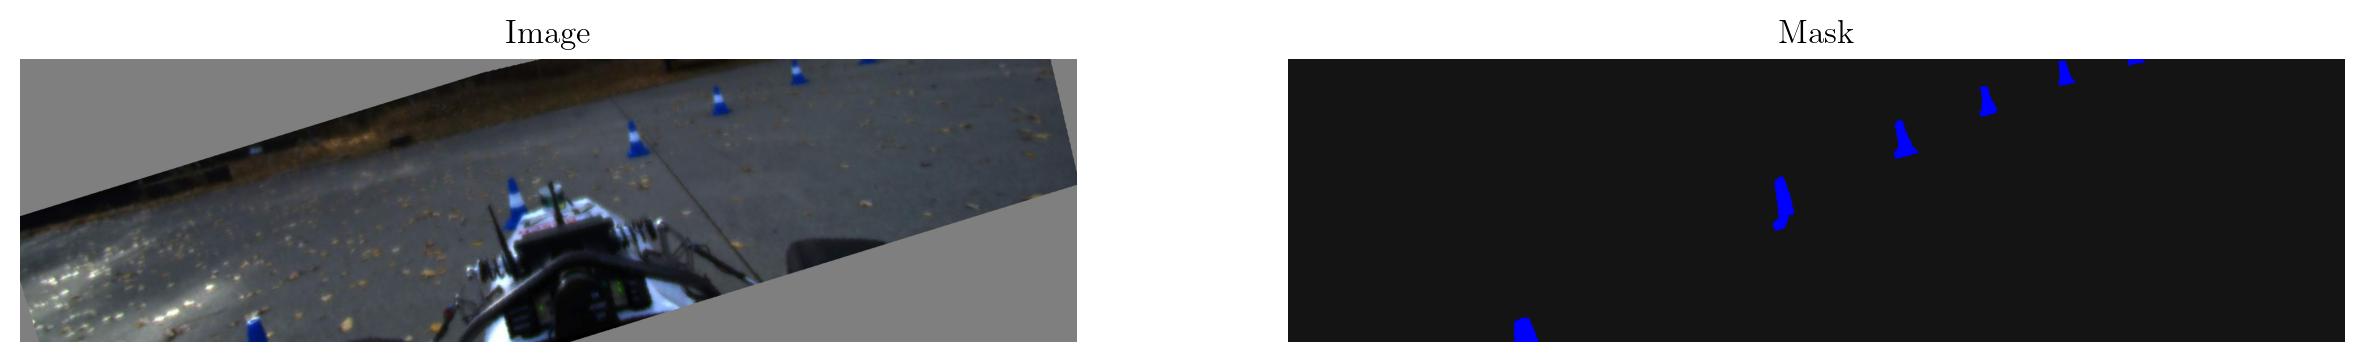

In [87]:
class_color_jitter = {
    0: {"hue": 0.5, "saturation": 0.5},
    1: {"hue": 0.5, "saturation": 0.8},
    2: {"hue": 0.5, "saturation": 0.8},
    3: {"hue": 0.5, "saturation": 0.8},
    4: {"hue": 0.5, "saturation": 0.8},
    5: {"hue": 0.5, "saturation": 0.8},
}

T = transforms.Compose(
    [
        Normalize(),
        RandomHorizontalFlipWithMask(0.5),
        RandomAffineWithMask(degrees=10, translate=(0.01, 0.01)),
        RandomRotationWithMask(
            degrees=20),
        ClasswiseColorJitter(class_color_jitter)
    ])

dataset = ConeSegmentationDataset(img_mask_pairs, transform=T)

for i in range(10):
    test_img, test_mask = dataset[i]
    visualize_from_torch(test_img, test_mask)

# Visualize Output


In [ ]:
from fastseg.image.colorize import colorize, blend

# Open image from file and resize it to lower memory footprint
img = Image.open('image.png').resize((1024, 512))

# Change the class from PIL.Image into numpy array
img_np = np.asarray(img)

# Create torch tensor from numpy array and add dimension representing batchsize. Also change dtype to float as it is required by torch
x = torch.tensor(img_np).unsqueeze(0).float()

# Transpose dimension of tensor so it respects the torch convention: Batch Size x Number of Classes x Height x Width
x = x.permute(0, 3, 1, 2)

# Normalize data
x = (x / 255) * 2 - 1

# Forward pass, input image x and return output probabilities for each pixel and each class along each image in batch size
output = model(x)

# Output in
print("Following is for the first pixel [0,0] of first image in batch [0]: \n")
print('Logits: \n', output[0, :, 0, 0], '\n')
print('Probabilities: \n', output.softmax(dim=1)[0, :, 0, 0], '\n')
print('Prediction: \n', output.argmax(dim=1)[0, 0, 0], '\n')

In [ ]:
# Calculation of final segmentation prediction from class probabilities along dimension 1
# detach.cpu.numpy transfer tensor from torch to computational graph-detached, to cpu memory and to numpy array instead of tensor
seg_np = output.argmax(dim=1)[0].detach().cpu().numpy()

# Function from fastseg to visualize images and output segmentation
seg_img = colorize(seg_np)  # <---- input is numpy, output is PIL.Image
blended_img = blend(img, seg_img)  # <---- input is PIL.Image in both arguments

# Concatenate images for simultaneous view
new_array = np.concatenate(
    (np.asarray(blended_img), np.asarray(seg_img)), axis=1)

# Show image from PIL.Image class
combination = Image.fromarray(new_array)
# combination.show()

# Input Image - Output

![alt text](input-output.png "i/o")


# Training Data

- Shuffle the data every training loop to prevent overfitting on examples one by one
- Feed the inputs in batches, so it can see "the most" of the things at once to prevent overfitting
  - you can use https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- Data Augmentation for extending training samples and therefore catch more configurations of objects
  - https://pytorch.org/vision/stable/transforms.html
  - https://pytorch.org/vision/0.12/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py


In [ ]:
# Already implemented data augmentations in torch vision
import torchvision.transforms as T

# Example of rotating input image to show different "views" on objects
# will rotate the image and the segmentation mask differently!!!
rotater = T.RandomRotation(degrees=(0, 180))
orig_img = torch.from_numpy(np.asarray(Image.open('image.png').resize(
    (1024, 512)))).permute(2, 0, 1).unsqueeze(0).float()

# Just visualization
seg_img = torch.from_numpy(seg_np).unsqueeze(0).float()
Image.fromarray(rotater(seg_img).to(torch.uint8).numpy()[0]).show()
# Just visualization
rotated_img = rotater(orig_img).to(torch.uint8)
Image.fromarray(rotated_img[0].permute(1, 2, 0).numpy()).show()

In [ ]:
# Cross entropy loss module. Basically softmax + negative log-likelihood.
# Softmax chains the output probabilities and set it between values 0-1
# Negative log-likelihood makes the values behaves more smoothly and penalize values like 0.1 much more than 0.9.
# weight argument sets the penalization per-class. When there is too much of the background, the model will overfit on majority class during training (background)
# You should calculate the number of pixels per class to avoid the overfit and specify the ratio in CrossEntropyLoss torch module.
CE = torch.nn.CrossEntropyLoss(reduction="none", weight=None)

# Get final prediction with argmax
labels = output.argmax(dim=1)

 <img src="neg_log.png" width="400">


In [ ]:
# Initialize model, can be from pretrained version (prefered). Here it is for educational purposes
num_classes = 19
model = MobileV3Small(num_classes=num_classes)

# Set up model to training mode (some layers are designed to behave differently during learning and during inference - batch norm for example.)
# Always learn model in training mode
model.train()

# Set up optimizer to automatically update weights with respect to computed loss and negative of gradient
# Regularization weight decay - analogy with remembering the exam questions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Multiple iterations (epochs)
for e in range(100):

    # Forward pass of model. Input image x and output as per-pixel probabilities, per-image in batch
    # output dimensions: Batch Size x Class probs x H x W
    output = model(x)

    # Calculation of Loss function, we use pytorch implementations of Cross entropy (softmax + negative log-likelihood)
    loss = CE(output, labels)

    # Print loss and metric Intersection-over-union to monitor model's performance during the training
    # Why there is non-zero loss when learning on the self-produced labels?
    print(f'Epoch: {e:03d}', f'Loss: {loss.mean().item():.4f}')

    # This step is the most important. On the backend, Torch will accumulate gradients along the performed operations and keeps it in the memory
    # After calling backward(), the gradients are recomputed for specific forward pass and the model accumulates gradients with respect to the loss
    loss.mean().backward()

    # After we compute the gradients from backward(), each weight in the model will have the .grad value.
    # Optimizer will then use the gradient and learning rate to update the weights
    optimizer.step()

    # Test if the models has accumulated gradients and therefore "learn something"
    if e == 0:
        print("Gradient in the last layer on specific weights: ",
              model.last.weight[0, 0, 0, 0])

    # Clean already used gradients to start over in the new iteration
    optimizer.zero_grad()

    # Visualization of model's output at every iterations
    seg_np = output.argmax(dim=1)[0].detach().cpu().numpy()
    seg_img = colorize(seg_np)
    seg_img.save(f'overfitting/{e:03d}.png')


# Saving weights
torch.save(model.state_dict(), 'weights/model.pth')

In [ ]:
# Loading trained model
model.load_state_dict(torch.load('weights/model.pth', map_location='cpu'))

# Setting model to eval mode
# Always test model in eval mode
model.eval()